In [8]:
%reset -f
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
import scipy as sc
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate
%matplotlib notebook

ticksize= 12
titlesize = 18
mpl.rcParams.update({'font.size':ticksize }) # legend
mpl.rcParams.update({'ytick.labelsize':ticksize })
mpl.rcParams.update({'xtick.labelsize':ticksize})
mpl.rcParams.update({'axes.labelsize':titlesize})    # x,y,cbar labels
mpl.rcParams.update({'figure.titlesize':titlesize})
mpl.rcParams.update({'axes.titlesize':titlesize})       # Title
mpl.rcParams.update({'savefig.bbox':'tight'})
mpl.rcParams.update({'axes.formatter.limits':[-4,4]})
mpl.rcParams.update({'figure.figsize':[6,5]})
mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.style':'normal'})
mpl.rcParams.update({'image.cmap':'rainbow'})

mpl.rcParams.update({'axes.formatter.useoffset':True})   # False ->no offset of axis
mpl.rcParams.update({'axes.formatter.use_mathtext':True}) # Change from 1e4 to 10^4 

np.set_printoptions(precision=3,suppress=True) 
plt.close('all')

In [9]:
a = 0
b = 20
ab = (b-a)*.5
sig = 1
Nx = 200
x = np.linspace(a,b,Nx)
dx = x[1]-x[0]
xe= np.linspace(a-dx*.5,b+dx*.5,Nx+1) #(x[1:]+x[:-1])*.5
psi0 = np.exp(-(x -ab)**2/sig**2*.5)

def DD(x):
    rel = (x-a)/(b-a) * 1
    return 1e-1*(.1+rel+rel**2 + np.sin(rel))
D = DD(x)

# ft1 = D*dx(dx(f)) = Di * der2
# ft2 = dx(D*dx(f)) = Di+*(fi+1 - fi) + Di-*(fi - fi-1)
# ft3 = dx(dx(D*f)) = der2 (Df)
der2 = (np.eye(Nx,k=-1)+np.eye(Nx,k=1)-2*np.eye(Nx))/(dx**2)
dydt_1 = der2*(D[:,np.newaxis])
dydt_3 = der2*D

# Finite volume
der1L = ( np.eye(Nx) -np.eye(Nx,k=-1))/dx**2
der1R = (-np.eye(Nx) +np.eye(Nx,k=1))/dx**2
coeffEdge=DD(xe)
FVRe = coeffEdge[1:,np.newaxis]*der1R
FVLe = coeffEdge[:-1,np.newaxis]*der1L
dydt_2 = (FVRe-FVLe)
      
tmax = 10
ts = np.linspace(0,tmax,100)
def dpsidt(psi,t,r,A):
    res = A.dot(psi)
    res[0]=0 #Dirichlet
    res[-1]=0
    return res


def sdpsidt(spsi,t,r,sA):
    res = sA.dot(spsi)
    res[0] = 0
    res[-1]= 0
    return res

psis1 = sc.integrate.odeint(dpsidt,psi0,ts,args=(x,dydt_1))
psis2 = sc.integrate.odeint(dpsidt,psi0,ts,args=(x,dydt_2))
psis3 = sc.integrate.odeint(dpsidt,psi0,ts,args=(x,dydt_3))

A = dydt_3
sA = sp.csc_matrix(A)
psis4 = sc.integrate.odeint(sdpsidt,psi0,ts,args=(x,sA))

In [3]:
%%timeit 
psis3 = sc.integrate.odeint(dpsidt,psi0,ts,args=(x,dydt_3))

21.5 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit
A = dydt_3
sA = sp.dia_matrix(A)
# sx = sp.diags(x,0)
dpsidtFV_ivp=lambda t, y: sdpsidt(y,t, x,sA)


919 µs ± 84.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
%%timeit
psis4 = sc.integrate.odeint(sdpsidt,psi0,ts,args=(x,sA))

25.9 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%timeit
psis4 = sc.integrate.solve_ivp(dpsidtFV_ivp,t_span=[0,np.max(ts)],y0=psi0,t_eval=ts,method='BDF')

NameError: name 'dpsidtFV_ivp' is not defined

<IPython.core.display.Javascript object>


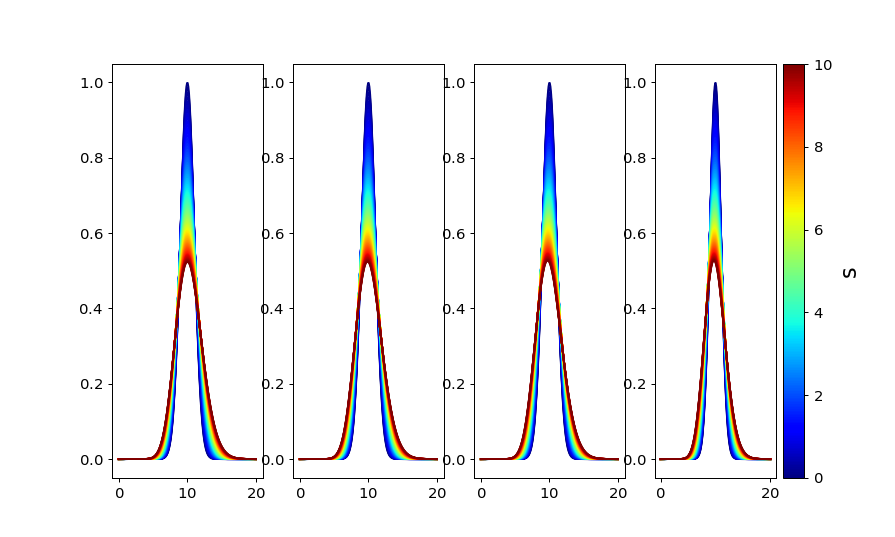

<IPython.core.display.Javascript object>


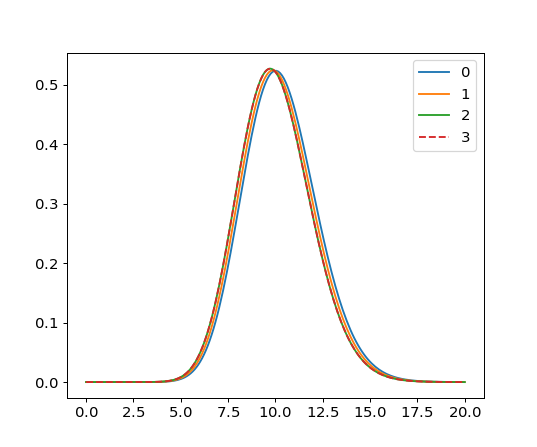

0 <class 'numpy.ndarray'> (100, 200)
1 <class 'numpy.ndarray'> (100, 200)
2 <class 'numpy.ndarray'> (100, 200)
3 <class 'numpy.ndarray'> (100, 200)


In [10]:
PSIS = [psis1,psis2,psis3,psis4]

time_scale=1
tlabel='s'
fig1, ax1 = plt.subplots(figsize=(10,6),dpi=100,ncols=len(PSIS))
norm = mpl.colors.Normalize(vmin=ts.min()/time_scale, vmax=ts.max()/time_scale)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])

fig2 = plt.figure()
ax2 = plt.gca()

for i,psis in enumerate(PSIS):
    print(i,type(psis),psis.shape)
    for j , t in enumerate(ts):
        ax1[i].plot(x,psis[j,:], c=cmap.to_rgba(t/time_scale))
        
    ax2.plot(x,psis[-1,:],['-','--'][i>2],label=i)
        
    #ax1[i].set_yscale('log')
cb=fig1.colorbar(cmap,label=tlabel) #ticks = np.linspace(0,tmax/time_scale,4),
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()


ax2.legend(loc=0)

In [40]:
print(der2_1)
print(der2_3)

[[ -0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.  -2.   1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   2.  -4.   2.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   3.  -6.   3.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   4.  -8.   4.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   5. -10.   5.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   6. -12.   6.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   7. -14.   7.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   8. -16.   8.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   9. -18.   9.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  10. -20.]]
[[ -0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  -2.   2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.  -4.   3.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   2.  -6.   4.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   3.  -8.   5.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   4. -10.   6.   0.   0.   0.   0.]
 [  0.   0.  